# CNN_4channel

Abstract:
- single channel: band_avg
- CNN, small net


References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_4channel'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_CNN_4channel_20171101_142927


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Load data

In [7]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [8]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)

(1604, 5)
(8424, 4)
Wall time: 20 s


In [9]:
#get numpy arrays for train/test data, prob there is a more pythonic approach
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])
    
#get numpy array for test data
band1test = pd_test['band_1'].values
im1test = np.zeros((len(band1test),len(band1test[0])))
for j in range(len(band1test)):
    im1test[j,:]=np.asarray(band1test[j])
    
band2test = pd_test['band_2'].values
im2test = np.zeros((len(band2test),len(band2test[0])))
for j in range(len(band2test)):
    im2test[j,:]=np.asarray(band2test[j])

In [10]:
print(pd_data['id'].values.shape)
print(pd_data['band_1'].values.shape)
print(pd_data['band_2'].values.shape)
print(pd_data['inc_angle'].values.shape)
print(pd_data['is_iceberg'].values.shape)

(1604,)
(1604,)
(1604,)
(1604,)
(1604,)


In [11]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
print(id_data.shape)
print(id_test.shape)

(1604,)
(8424,)


In [12]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)/100
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)/100
print(inc_angle_data.shape)
print(inc_angle_data[0:2])
print(inc_angle_test.shape)
print(inc_angle_test[0:2])

(1604,)
0    0.439239
1    0.381562
Name: inc_angle, dtype: float64
(8424,)
0    0.349664
1    0.326151
Name: inc_angle, dtype: float64


In [13]:
y_data = pd_data['is_iceberg']
print(y_data.shape)

(1604,)


In [14]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1test.reshape(-1, 75,75)
band2_test = im2test.reshape(-1, 75,75)

print(band1_data.shape)
print(band2_data.shape)
print(band1_test.shape)
print(band2_test.shape)

(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


In [15]:
band_avg_data = (band1_data + band2_data)/2
print(band_avg_data.shape)
band_avg_test = (band1_test + band2_test)/2
print(band_avg_test.shape)

(1604, 75, 75)
(8424, 75, 75)


(75, 75)


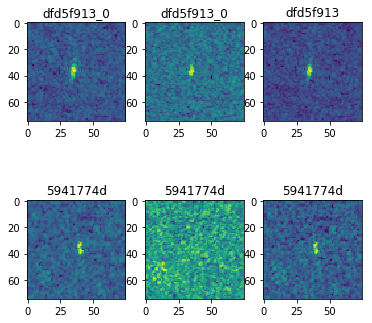

In [16]:
# Preview images
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[0].reshape(75, 75))
ax[0, 0].set_title(id_data[0] + '_' + str(y_data[0]))
ax[0, 1].imshow(band2_data[0].reshape(75, 75))
ax[0, 1].set_title(id_data[0] + '_' + str(y_data[1]))
ax[0, 2].imshow(band_avg_data[0].reshape(75, 75))
ax[0, 2].set_title(id_data[0])

ax[1, 0].imshow(band1_test[0].reshape(75, 75))
ax[1, 0].set_title(id_test[0])
ax[1, 1].imshow(band2_test[0].reshape(75, 75))
ax[1, 1].set_title(id_test[0])
ax[1, 2].imshow(band_avg_test[0].reshape(75, 75))
ax[1, 2].set_title(id_test[0])

In [17]:
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [18]:
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(inc_angle_train.shape)
print(inc_angle_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 3)
(241, 75, 75, 3)
(1363,)
(241,)
(1363,)
(241,)


## 2. Build model

In [19]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [20]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(75, 75, 3), name="bands")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation)(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)

    img_1 = GlobalMaxPooling2D() (img_1)
    
#     img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation)(input_1)
#     img_2 = BatchNormalization()(img_2)
#     img_2 = MaxPooling2D((2,2)) (img_2)
#     img_2 = Dropout(0.2)(img_2)
#     img_2 = GlobalMaxPooling2D() (img_2)
    
    angle = BatchNormalization()(input_2)
    img_concat = (Concatenate()([img_1, angle]))
    
#     img_concat = Concatenate([img_1, input_2])
    
    dense_ayer = Dense(1024, activation=p_activation)(img_concat)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.5)(dense_ayer)
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
#     optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [21]:
# def build_model():
#     model = Sequential()

#     model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
#                      input_shape = (75, 75, 3)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(strides=(2,2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(units = 1, activation = 'sigmoid'))

#     model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return model

In [22]:
model = build_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
bands (InputLayer)               (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 73, 73, 32)    896         bands[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 73, 73, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 71, 71, 32)    9248        batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [23]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [24]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_4channel_20171101_142927


In [25]:
hist = model.fit([x_train, inc_angle_train], y_train, 
                 batch_size = 8, 
                 verbose= 1,
                 epochs = 50, #1 for ETA, 0 for silent
                 validation_data=([x_val, inc_angle_val], y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
Epoch 1/50
1363/1363 [==============================] - 27s - loss: 0.7980 - acc: 0.6794 - val_loss: 1.0179 - val_acc: 0.4855
Epoch 2/50
1363/1363 [==============================] - 24s - loss: 0.6064 - acc: 0.7461 - val_loss: 0.4589 - val_acc: 0.7801
Epoch 3/50
1363/1363 [==============================] - 24s - loss: 0.5386 - acc: 0.7799 - val_loss: 0.7193 - val_acc: 0.6805
Epoch 4/50
1363/1363 [==============================] - 24s - loss: 0.4423 - acc: 0.8283 - val_loss: 0.4567 - val_acc: 0.7967
Epoch 5/50
1363/1363 [==============================] - 24s - loss: 0.4279 - acc: 0.8180 - val_loss: 0.3924 - val_acc: 0.8216
Epoch 6/50
1363/1363 [==============================] - 24s - loss: 0.3948 - acc: 0.8364 - val_loss: 0.3771 - val_acc: 0.8133
Epoch 7/50
1363/1363 [==============================] - 24s - loss: 0.4127 - acc: 0.8276 - val_loss: 0.2836 - val_acc: 0.8838
Epoch 8/50
1363/1363 [==============================] - 24s - loss: 0.3

In [26]:
final_loss, final_acc = model.evaluate([x_val, inc_angle_val], y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

241/241 [==============================] - 1s     
Final loss: 0.3738, final accuracy: 0.8797


In [27]:
val_prob1 = model.predict([x_val, inc_angle_val])

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.37382764037461147
Val log_loss: 0.3326194518674706


In [28]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_4channel_20171101_142927_3326


In [29]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


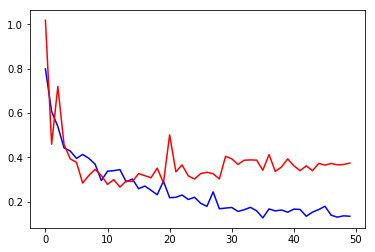

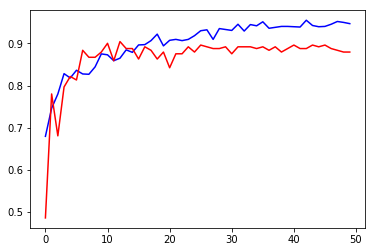

In [30]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [31]:
saveModel(model, run_name_acc)

## 3. Predict

In [32]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_4channel_20171101_142927_3326.csv


In [33]:
test_prob = model.predict([x_test, inc_angle_test])
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.00373735]
 [ 0.2423747 ]]
(8424, 1)
[[ 0.05     ]
 [ 0.2423747]]


In [34]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.050000
1  4023181e    0.242375
(8424, 2)


In [35]:
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_4channel_20171101_142927_3326
Done!
